In [1]:
# Google Drive Connect
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
# Dataset Zip file Extract
import zipfile
import os

zip_path = "/content/drive/MyDrive/Data_Classification.zip"  # Pathway
extract_path = "/content/data"  # Pathway

# Zip file Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Dataset extracted to {extract_path}")

# ✅ 올바른 디렉토리만 출력 (MACOSX 및 중첩 폴더 제거)
for root, dirs, files in os.walk(extract_path):
    # 🚨 '__MACOSX' 폴더가 포함된 경로는 건너뜀
    if "__MACOSX" in root:
        continue

    # 🚨 '/CNV/CNV' 같은 중첩 폴더 방지
    path_parts = root.split("/")
    if len(path_parts) > 2 and path_parts[-1] == path_parts[-2]:
        continue  # 예: train/CNV/CNV 같은 폴더 무시

    print(f"Directory: {root}")

    for file in files[:5]:  # 최대 5개 파일만 출력
        print(f"  File: {file}")

Dataset extracted to /content/data
Directory: /content/data
Directory: /content/data/oct2017
Directory: /content/data/oct2017/OCT2017 
  File: .DS_Store
Directory: /content/data/oct2017/OCT2017 /test
  File: .DS_Store
Directory: /content/data/oct2017/OCT2017 /test/NORMAL
  File: NORMAL-1957379-1.jpeg
  File: NORMAL-3354044-1.jpeg
  File: NORMAL-3277704-1.jpeg
  File: NORMAL-519372-1.jpeg
  File: NORMAL-349021-1.jpeg
Directory: /content/data/oct2017/OCT2017 /test/DRUSEN
  File: DRUSEN-8086850-4.jpeg
  File: DRUSEN-8086850-2.jpeg
  File: DRUSEN-8074563-1.jpeg
  File: DRUSEN-4343867-1.jpeg
  File: DRUSEN-3317878-1.jpeg
Directory: /content/data/oct2017/OCT2017 /test/DME
  File: DME-8019418-4.jpeg
  File: DME-1102486-1.jpeg
  File: DME-8177380-3.jpeg
  File: DME-7939555-4.jpeg
  File: DME-8167779-1.jpeg
Directory: /content/data/oct2017/OCT2017 /test/CNV
  File: CNV-2192440-2.jpeg
  File: CNV-451136-4.jpeg
  File: CNV-1016042-3.jpeg
  File: CNV-172472-5.jpeg
  File: CNV-2158821-1.jpeg
Direct

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from tqdm import trange

# Define Dataset Class
class RetinaDataset(Dataset):
    def __init__(self, CNV_dir, DME_dir, DRUSEN_dir, NORMAL_dir, transform=None):
        self.transform = transform
        self.data = []  # Image Path / Label Recorded List

        # CNV 데이터 추가
        for img_name in sorted(os.listdir(CNV_dir)):
            self.data.append((os.path.join(CNV_dir, img_name), 0))  # Label: 0

        # DME 데이터 추가
        for img_name in sorted(os.listdir(DME_dir)):
            self.data.append((os.path.join(DME_dir, img_name), 1))  # Label: 1

        # DRUSEN 데이터 추가
        for img_name in sorted(os.listdir(DRUSEN_dir)):
            self.data.append((os.path.join(DRUSEN_dir, img_name), 2))  # Label: 2

        # NORMAL 데이터 추가
        for img_name in sorted(os.listdir(NORMAL_dir)):
            self.data.append((os.path.join(NORMAL_dir, img_name), 3))  # Label: 3

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("L")  # Grayscale

        if self.transform:
            image = self.transform(image)

        return image, label # Returning Label as well

# Data Path Setting
TRAIN_CNV_PATH = os.path.join(extract_path, "OCT2017 /train/CNV")
TRAIN_DME_PATH = os.path.join(extract_path, "OCT2017 /train/DME")
TRAIN_DRUSEN_PATH = os.path.join(extract_path, "OCT2017 /train/DRUSEN")
TRAIN_NORMAL_PATH = os.path.join(extract_path, "OCT2017 /train/NORMAL")

VALID_CNV_PATH = os.path.join(extract_path, "OCT2017 /val/CNV")
VALID_DME_PATH = os.path.join(extract_path, "OCT2017 /val/DME")
VALID_DRUSEN_PATH = os.path.join(extract_path, "OCT2017 /val/DRUSEN")
VALID_NORMAL_PATH = os.path.join(extract_path, "OCT2017 /val/NORMAL")

TEST_CNV_PATH = os.path.join(extract_path, "OCT2017 /test/CNV")
TEST_DME_PATH = os.path.join(extract_path, "OCT2017 /test/DME")
TEST_DRUSEN_PATH = os.path.join(extract_path, "OCT2017 /test/DRUSEN")
TEST_NORMAL_PATH = os.path.join(extract_path, "OCT2017 /test/NORMAL")

# Data Transform
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])
import os
import shutil

base_path = "/content/data/OCT2017 /train"  # OCT2017 뒤에 공백 포함 여부 확인!

# ✅ 클래스별 폴더 확인 후 불필요한 중첩 폴더 삭제
for category in ["CNV", "DME", "DRUSEN", "NORMAL"]:
    category_path = os.path.join(base_path, category)

    # ✅ 올바른 경로인지 확인
    if not os.path.exists(category_path):
        print(f"🚨 Error: {category_path} does not exist!")
        continue

    # ✅ 내부 폴더 목록 확인
    inner_folders = [f for f in os.listdir(category_path) if os.path.isdir(os.path.join(category_path, f))]

    # ✅ 불필요한 중첩 폴더 삭제
    for folder in inner_folders:
        redundant_path = os.path.join(category_path, folder)
        if folder == category:  # 예: CNV/CNV 같은 중복 폴더
            print(f"🗑 Deleting redundant folder: {redundant_path}")
            shutil.rmtree(redundant_path)  # 폴더 삭제

print("✅ Folder cleanup complete!")
# Gathered Dataset
train_dataset = RetinaDataset(TRAIN_CNV_PATH,
                              TRAIN_DME_PATH,
                              TRAIN_DRUSEN_PATH,
                              TRAIN_NORMAL_PATH,
                              transform=transform)

valid_dataset = RetinaDataset(VALID_CNV_PATH,
                              VALID_DME_PATH,
                              VALID_DRUSEN_PATH,
                              VALID_NORMAL_PATH,
                              transform=transform)
test_dataset = RetinaDataset(TEST_CNV_PATH,
                             TEST_DME_PATH,
                             TEST_DRUSEN_PATH,
                             TEST_NORMAL_PATH,
                             transform=transform)

# ✅ 개별 Train Dataset 설정
train_dataset_CNV = RetinaDataset(TRAIN_CNV_PATH, TRAIN_CNV_PATH, TRAIN_CNV_PATH, TRAIN_CNV_PATH, transform=transform)
train_dataset_DME = RetinaDataset(TRAIN_DME_PATH, TRAIN_DME_PATH, TRAIN_DME_PATH, TRAIN_DME_PATH, transform=transform)
train_dataset_DRUSEN = RetinaDataset(TRAIN_DRUSEN_PATH, TRAIN_DRUSEN_PATH, TRAIN_DRUSEN_PATH, TRAIN_DRUSEN_PATH, transform=transform)
train_dataset_NORMAL = RetinaDataset(TRAIN_NORMAL_PATH, TRAIN_NORMAL_PATH, TRAIN_NORMAL_PATH, TRAIN_NORMAL_PATH, transform=transform)

# ✅ 개별 Validation Dataset 설정
valid_dataset_CNV = RetinaDataset(VALID_CNV_PATH, VALID_CNV_PATH, VALID_CNV_PATH, VALID_CNV_PATH, transform=transform)
valid_dataset_DME = RetinaDataset(VALID_DME_PATH, VALID_DME_PATH, VALID_DME_PATH, VALID_DME_PATH, transform=transform)
valid_dataset_DRUSEN = RetinaDataset(VALID_DRUSEN_PATH, VALID_DRUSEN_PATH, VALID_DRUSEN_PATH, VALID_DRUSEN_PATH, transform=transform)
valid_dataset_NORMAL = RetinaDataset(VALID_NORMAL_PATH, VALID_NORMAL_PATH, VALID_NORMAL_PATH, VALID_NORMAL_PATH, transform=transform)

# ✅ 개별 Test Dataset 설정
test_dataset_CNV = RetinaDataset(TEST_CNV_PATH, TEST_CNV_PATH, TEST_CNV_PATH, TEST_CNV_PATH, transform=transform)
test_dataset_DME = RetinaDataset(TEST_DME_PATH, TEST_DME_PATH, TEST_DME_PATH, TEST_DME_PATH, transform=transform)
test_dataset_DRUSEN = RetinaDataset(TEST_DRUSEN_PATH, TEST_DRUSEN_PATH, TEST_DRUSEN_PATH, TEST_DRUSEN_PATH, transform=transform)
test_dataset_NORMAL = RetinaDataset(TEST_NORMAL_PATH, TEST_NORMAL_PATH, TEST_NORMAL_PATH, TEST_NORMAL_PATH, transform=transform)




# DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# ✅ 개별 Train DataLoader 설정
train_loader_CNV = DataLoader(train_dataset_CNV, batch_size=32, shuffle=True, num_workers=4)
train_loader_DME = DataLoader(train_dataset_DME, batch_size=32, shuffle=True, num_workers=4)
train_loader_DRUSEN = DataLoader(train_dataset_DRUSEN, batch_size=32, shuffle=True, num_workers=4)
train_loader_NORMAL = DataLoader(train_dataset_NORMAL, batch_size=32, shuffle=True, num_workers=4)

# ✅ 개별 Validation DataLoader 설정
valid_loader_CNV = DataLoader(valid_dataset_CNV, batch_size=32, shuffle=False, num_workers=4)
valid_loader_DME = DataLoader(valid_dataset_DME, batch_size=32, shuffle=False, num_workers=4)
valid_loader_DRUSEN = DataLoader(valid_dataset_DRUSEN, batch_size=32, shuffle=False, num_workers=4)
valid_loader_NORMAL = DataLoader(valid_dataset_NORMAL, batch_size=32, shuffle=False, num_workers=4)

# ✅ 개별 Test DataLoader 설정
test_loader_CNV = DataLoader(test_dataset_CNV, batch_size=32, shuffle=False, num_workers=4)
test_loader_DME = DataLoader(test_dataset_DME, batch_size=32, shuffle=False, num_workers=4)
test_loader_DRUSEN = DataLoader(test_dataset_DRUSEN, batch_size=32, shuffle=False, num_workers=4)
test_loader_NORMAL = DataLoader(test_dataset_NORMAL, batch_size=32, shuffle=False, num_workers=4)

print("✅ All DataLoaders successfully created with direct folder specification!")

✅ Folder cleanup complete!
✅ All DataLoaders successfully created with direct folder specification!


In [4]:
import os
import random

# Setting Path
train_base_path = "/content/data/OCT2017 /train"
train_count = 600  # Amount of Data for each class

# Max 600 per class
for category in ["CNV", "DME", "DRUSEN", "NORMAL"]:
    category_path = os.path.join(train_base_path, category)
    files = os.listdir(category_path)
    files = [f for f in files if os.path.isfile(os.path.join(category_path, f))]  # Only file

    if len(files) > train_count:
        # Choose random 600 data
        files_to_keep = random.sample(files, train_count)
        files_to_delete = set(files) - set(files_to_keep)

        # Delete other files
        for file_name in files_to_delete:
            os.remove(os.path.join(category_path, file_name))
        print(f"{category}: Reduced to {train_count} samples.")
    else:
        print(f"{category}: Already has {len(files)} samples (No action needed).")

# Setting Path
valid_base_path = "/content/data/OCT2017 /val"
valid_count = 200  # Amount of Data for each class

# Max 200 per class
for category in ["CNV", "DME", "DRUSEN", "NORMAL"]:
    category_path = os.path.join(valid_base_path, category)
    files = os.listdir(category_path)
    files = [f for f in files if os.path.isfile(os.path.join(category_path, f))]  # Only file

    if len(files) > valid_count:
        # Choose random 200 data
        files_to_keep = random.sample(files, valid_count)
        files_to_delete = set(files) - set(files_to_keep)

        # Delete other files
        for file_name in files_to_delete:
            os.remove(os.path.join(category_path, file_name))
        print(f"{category}: Reduced to {valid_count} samples.")
    else:
        print(f"{category}: Already has {len(files)} samples (No action needed).")

# Setting Path
test_base_path = "/content/data/OCT2017 /test"
test_count = 200  # Amount of Data for each class

# Max 200 per class
for category in ["CNV", "DME", "DRUSEN", "NORMAL"]:
    category_path = os.path.join(test_base_path, category)
    files = os.listdir(category_path)
    files = [f for f in files if os.path.isfile(os.path.join(category_path, f))]  # 파일만 선택

    if len(files) > test_count:
        # Choose random 200 data
        files_to_keep = random.sample(files, test_count)
        files_to_delete = set(files) - set(files_to_keep)

        # Delete other files
        for file_name in files_to_delete:
            os.remove(os.path.join(category_path, file_name))
        print(f"{category}: Reduced to {test_count} samples.")
    else:
        print(f"{category}: Already has {len(files)} samples (No action needed).")

CNV: Reduced to 600 samples.
DME: Reduced to 600 samples.
DRUSEN: Reduced to 600 samples.
NORMAL: Reduced to 600 samples.
CNV: Reduced to 200 samples.
DME: Already has 200 samples (No action needed).
DRUSEN: Already has 200 samples (No action needed).
NORMAL: Already has 200 samples (No action needed).
CNV: Reduced to 200 samples.
DME: Reduced to 200 samples.
DRUSEN: Reduced to 200 samples.
NORMAL: Reduced to 200 samples.


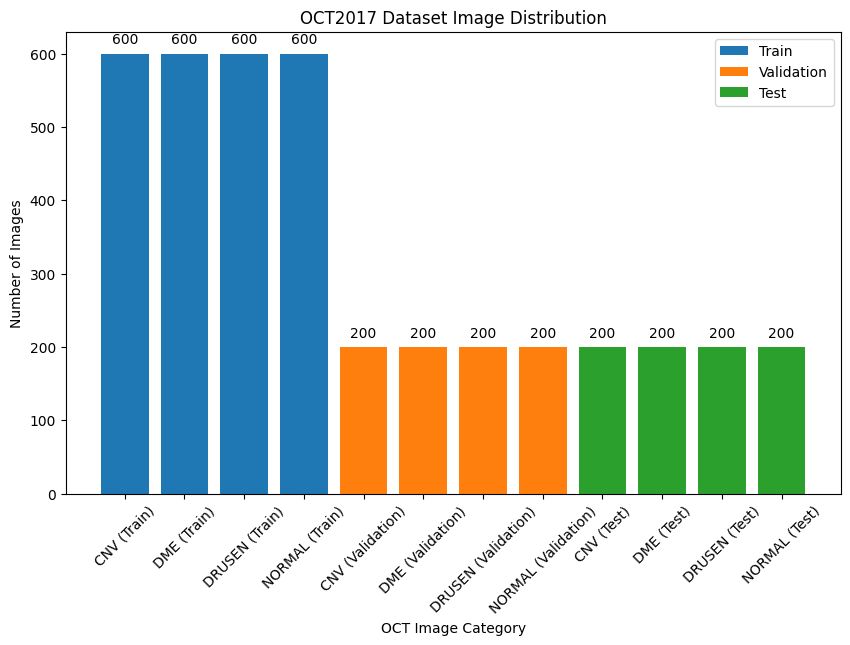

In [5]:
import os
import matplotlib.pyplot as plt
import pandas as pd

# Define dataset paths
extract_path = "/content/data"

data_dirs = {
    "Train": {
        "CNV": os.path.join(extract_path, "OCT2017 /train/CNV"),
        "DME": os.path.join(extract_path, "OCT2017 /train/DME"),
        "DRUSEN": os.path.join(extract_path, "OCT2017 /train/DRUSEN"),
        "NORMAL": os.path.join(extract_path, "OCT2017 /train/NORMAL"),
    },
    "Validation": {
        "CNV": os.path.join(extract_path, "OCT2017 /val/CNV"),
        "DME": os.path.join(extract_path, "OCT2017 /val/DME"),
        "DRUSEN": os.path.join(extract_path, "OCT2017 /val/DRUSEN"),
        "NORMAL": os.path.join(extract_path, "OCT2017 /val/NORMAL"),
    },
    "Test": {
        "CNV": os.path.join(extract_path, "OCT2017 /test/CNV"),
        "DME": os.path.join(extract_path, "OCT2017 /test/DME"),
        "DRUSEN": os.path.join(extract_path, "OCT2017 /test/DRUSEN"),
        "NORMAL": os.path.join(extract_path, "OCT2017 /test/NORMAL"),
    },
}

# Count the number of images in each category
data_distribution = []
for dataset_type, categories in data_dirs.items():
    for category, path in categories.items():
        count = len(os.listdir(path)) if os.path.exists(path) else 0
        data_distribution.append([dataset_type, category, count])

# Create a DataFrame
df_distribution = pd.DataFrame(data_distribution, columns=["Dataset", "Category", "Count"])

# Plot the distribution
fig, ax = plt.subplots(figsize=(10, 6))
bars = []

for dataset_type in df_distribution["Dataset"].unique():
    subset = df_distribution[df_distribution["Dataset"] == dataset_type]
    bars.extend(ax.bar(subset["Category"] + " (" + dataset_type + ")", subset["Count"], label=dataset_type))

# Add text annotations on top of bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 5),  # 5 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.xlabel("OCT Image Category")
plt.ylabel("Number of Images")
plt.title("OCT2017 Dataset Image Distribution")
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

class PatchMaskedAutoEncoder(nn.Module):
    def __init__(self, encoder, decoder, patch_size=16, image_size=512, mask_ratio=0.75):
        """
        patch_size: size of each patch (e.g., 16)
        image_size: assume input images are (image_size x image_size)
        mask_ratio: fraction of patches to mask out
        """
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

        self.patch_size = patch_size
        self.image_size = image_size
        self.mask_ratio = mask_ratio

    def forward(self, x):
        """
        x: (N, 3, H, W)
        """
        with torch.no_grad():
            latent = self.encoder(x)  # (N, C, H, W)
        reconstructed = self.decoder(latent)   # should come back to (N, 3, H, W)

        return reconstructed

In [7]:
# Save & Plot Loss Graphs
def save_loss_graphs(training_losses, validation_losses, lrs):
    torch.save(validation_losses, "validation_losses.pt")
    torch.save(training_losses, "training_losses.pt")

    # Training Loss
    plt.figure(figsize=(10, 5))
    plt.plot(training_losses, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Epochs")
    plt.legend()
    plt.savefig("training_losses.png")
    plt.show()

    # Validation Loss
    plt.figure(figsize=(10, 5))
    plt.plot(validation_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Validation Loss Over Epochs")
    plt.legend()
    plt.savefig("validation_losses.png")
    plt.show()

    # Learning Rate Plot
    plt.figure(figsize=(10, 5))
    plt.plot(lrs, label="Learning Rate")
    plt.xlabel("Epoch")
    plt.ylabel("Learning Rate")
    plt.title("Learning Rate Over Epochs")
    plt.legend()
    plt.savefig("learning_rate.png")
    print("\n🔹 Loss & Learning Rate Graphs Saved.\n")

In [8]:
import torch.nn as nn
import torch.optim as optim

##############################################################################
# 1. Residual Block
##############################################################################
class ResidualBlock(nn.Module):
    """
    A standard residual block with two 3x3 convolutions and a skip connection.
    """
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels,
                               kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # If shapes differ (due to stride), we use the 'downsample' layer
        if self.downsample is not None:
            identity = self.downsample(identity)

        # Residual connection
        out += identity
        out = self.relu(out)

        return out

In [9]:
##############################################################################
# 2. Modern Encoder
##############################################################################
class ModernEncoder(nn.Module):
    """
    A ResNet-like encoder that progressively downsamples.
    You can adjust `layers` to control depth, e.g. [2,2,2,2].
    """
    def __init__(self, layers=[2, 2, 2, 2], base_channels=64, in_channels=1):
        super(ModernEncoder, self).__init__()
        self.in_channels = base_channels

        # Initial convolution and pooling (similar to ResNet stem)
        self.conv1 = nn.Conv2d(in_channels, base_channels,
                               kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(base_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)

        # Residual layers
        self.layer1 = self._make_layer(base_channels,   layers[0], stride=1)  # 1/4 scale
        self.layer2 = self._make_layer(base_channels*2, layers[1], stride=2)  # 1/8 scale
        self.layer3 = self._make_layer(base_channels*4, layers[2], stride=2)  # 1/16 scale
        self.layer4 = self._make_layer(base_channels*8, layers[3], stride=2)  # 1/32 scale

    def _make_layer(self, out_channels, blocks, stride=1):
        """
        Create a stack of residual blocks, including a 'downsample'
        layer if channel dimension or stride is changed.
        """

        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )

        layers = []
        # First block in this layer
        layers.append(ResidualBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels

        # Remaining blocks
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        # Stem
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Downsampling stages
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        return x

In [10]:
##############################################################################
# 3. Modern Decoder
##############################################################################
class ModernDecoder(nn.Module):
    """
    A decoder that uses transpose convolutions (or could use upsampling + conv).
    Mirrors the encoder in reverse, but you can also add skip connections
    from the encoder if desired (like U-Net).
    """
    def __init__(self, base_channels=64, out_channels=1):
        super(ModernDecoder, self).__init__()

        # The decoder channels should match the encoder's last layer, i.e. base_channels*8
        # if you used the default layers=[2,2,2,2]. Adjust accordingly.

        self.up1 = nn.ConvTranspose2d(base_channels*8, base_channels*4, kernel_size=2, stride=2)
        self.res1 = ResidualBlock(base_channels*4, base_channels*4)

        self.up2 = nn.ConvTranspose2d(base_channels*4, base_channels*2, kernel_size=2, stride=2)
        self.res2 = ResidualBlock(base_channels*2, base_channels*2)

        self.up3 = nn.ConvTranspose2d(base_channels*2, base_channels, kernel_size=2, stride=2)
        self.res3 = ResidualBlock(base_channels, base_channels)

        # One more up if you want to get back to the original scale
        # (depending on the input image resolution).
        self.up4 = nn.ConvTranspose2d(base_channels, base_channels // 2, kernel_size=2, stride=2)
        self.res4 = ResidualBlock(base_channels // 2, base_channels // 2)

        self.up5 = nn.ConvTranspose2d(base_channels//2, base_channels//4, 2, 2)
        self.res5 = ResidualBlock(base_channels//4, base_channels//4)

        # Final 1x1 convolution to map to the desired number of output channels
        self.final_conv = nn.Conv2d(base_channels // 2, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.up1(x)
        x = self.res1(x)

        x = self.up2(x)
        x = self.res2(x)

        x = self.up3(x)
        x = self.res3(x)

        x = self.up4(x)
        x = self.res4(x)

        x = self.final_conv(x)
        x = self.sigmoid(x)

        return x

In [11]:
# Instantiate
encoder = ModernEncoder(in_channels=1)
decoder = ModernDecoder(out_channels=1)
model = PatchMaskedAutoEncoder(
    encoder, decoder,
    patch_size=16,
    image_size=512,
    mask_ratio=0.5
)

print(model)

PatchMaskedAutoEncoder(
  (encoder): ModernEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum

In [12]:
torch.cuda.empty_cache()
# Activate Garbage Collector
import gc
gc.collect()

0

In [13]:
import os
import shutil

# 🚨 Force to delete all the un-necessary nesting folders
problematic_path = "/content/data/OCT2017 /train/CNV/CNV"

if os.path.exists(problematic_path):
    print(f"🗑 Deleting problematic folder: {problematic_path}")
    shutil.rmtree(problematic_path)
else:
    print(f"✅ No redundant folder found: {problematic_path}")

✅ No redundant folder found: /content/data/OCT2017 /train/CNV/CNV


In [14]:
import os
import shutil

# 🚨 Force to delete all the un-necessary nesting folders
problematic_path = "/content/data/OCT2017 /val/CNV/CNV"

if os.path.exists(problematic_path):
    print(f"🗑 Deleting problematic folder: {problematic_path}")
    shutil.rmtree(problematic_path)
else:
    print(f"✅ No redundant folder found: {problematic_path}")

✅ No redundant folder found: /content/data/OCT2017 /val/CNV/CNV


In [15]:
import os
import shutil

# 🚨 Force to delete all the un-necessary nesting folders
problematic_path = "/content/data/OCT2017 /test/CNV/CNV"

if os.path.exists(problematic_path):
    print(f"🗑 Deleting problematic folder: {problematic_path}")
    shutil.rmtree(problematic_path)
else:
    print(f"✅ No redundant folder found: {problematic_path}")

✅ No redundant folder found: /content/data/OCT2017 /test/CNV/CNV


In [16]:
import os

valid_path = "/content/data/OCT2017 /val"

# 🚨 중첩된 폴더가 있는지 확인
for category in ["CNV", "DME", "DRUSEN", "NORMAL"]:
    category_path = os.path.join(valid_path, category)
    if os.path.exists(category_path):
        print(f"✅ Found category: {category_path}")
        print("Contents:", os.listdir(category_path))  # Print the interior File/Folders

✅ Found category: /content/data/OCT2017 /val/CNV
Contents: ['CNV-6666538-416.jpeg', 'CNV-460403-191.jpeg', 'CNV-781814-114.jpeg', 'CNV-2444883-94.jpeg', 'CNV-2158821-1.jpeg', 'CNV-7159021-50.jpeg', 'CNV-8892000-9.jpeg', 'CNV-5434564-50.jpeg', 'CNV-3947605-5.jpeg', 'CNV-6294785-1.jpeg', 'CNV-4020729-7.jpeg', 'CNV-7710023-53.jpeg', 'CNV-8184974-124.jpeg', 'CNV-163081-138.jpeg', 'CNV-1730592-25.jpeg', 'CNV-5674369-65.jpeg', 'CNV-4612183-57.jpeg', 'CNV-1986974-11.jpeg', 'CNV-7565927-211.jpeg', 'CNV-135126-17.jpeg', 'CNV-9997680-155.jpeg', 'CNV-830921-2.jpeg', 'CNV-6875371-1.jpeg', 'CNV-3847391-55.jpeg', 'CNV-7315522-154.jpeg', 'CNV-1699976-118.jpeg', 'CNV-3360009-2.jpeg', 'CNV-3715091-175.jpeg', 'CNV-2141150-2.jpeg', 'CNV-3734032-21.jpeg', 'CNV-1322624-166.jpeg', 'CNV-2120559-57.jpeg', 'CNV-4951152-16.jpeg', 'CNV-1260317-114.jpeg', 'CNV-904464-78.jpeg', 'CNV-904464-227.jpeg', 'CNV-1894770-33.jpeg', 'CNV-3734032-27.jpeg', 'CNV-7563760-49.jpeg', 'CNV-1390155-87.jpeg', 'CNV-7565927-169.jpeg',

In [19]:
# Gathered Dataset
train_dataset = RetinaDataset(TRAIN_CNV_PATH,
                              TRAIN_DME_PATH,
                              TRAIN_DRUSEN_PATH,
                              TRAIN_NORMAL_PATH,
                              transform=transform)

valid_dataset = RetinaDataset(VALID_CNV_PATH,
                              VALID_DME_PATH,
                              VALID_DRUSEN_PATH,
                              VALID_NORMAL_PATH,
                              transform=transform)
test_dataset = RetinaDataset(TEST_CNV_PATH,
                             TEST_DME_PATH,
                             TEST_DRUSEN_PATH,
                             TEST_NORMAL_PATH,
                             transform=transform)

# ✅ 개별 Train Dataset 설정
train_dataset_CNV = RetinaDataset(TRAIN_CNV_PATH, TRAIN_CNV_PATH, TRAIN_CNV_PATH, TRAIN_CNV_PATH, transform=transform)
train_dataset_DME = RetinaDataset(TRAIN_DME_PATH, TRAIN_DME_PATH, TRAIN_DME_PATH, TRAIN_DME_PATH, transform=transform)
train_dataset_DRUSEN = RetinaDataset(TRAIN_DRUSEN_PATH, TRAIN_DRUSEN_PATH, TRAIN_DRUSEN_PATH, TRAIN_DRUSEN_PATH, transform=transform)
train_dataset_NORMAL = RetinaDataset(TRAIN_NORMAL_PATH, TRAIN_NORMAL_PATH, TRAIN_NORMAL_PATH, TRAIN_NORMAL_PATH, transform=transform)

# ✅ 개별 Validation Dataset 설정
valid_dataset_CNV = RetinaDataset(VALID_CNV_PATH, VALID_CNV_PATH, VALID_CNV_PATH, VALID_CNV_PATH, transform=transform)
valid_dataset_DME = RetinaDataset(VALID_DME_PATH, VALID_DME_PATH, VALID_DME_PATH, VALID_DME_PATH, transform=transform)
valid_dataset_DRUSEN = RetinaDataset(VALID_DRUSEN_PATH, VALID_DRUSEN_PATH, VALID_DRUSEN_PATH, VALID_DRUSEN_PATH, transform=transform)
valid_dataset_NORMAL = RetinaDataset(VALID_NORMAL_PATH, VALID_NORMAL_PATH, VALID_NORMAL_PATH, VALID_NORMAL_PATH, transform=transform)

# ✅ 개별 Test Dataset 설정
test_dataset_CNV = RetinaDataset(TEST_CNV_PATH, TEST_CNV_PATH, TEST_CNV_PATH, TEST_CNV_PATH, transform=transform)
test_dataset_DME = RetinaDataset(TEST_DME_PATH, TEST_DME_PATH, TEST_DME_PATH, TEST_DME_PATH, transform=transform)
test_dataset_DRUSEN = RetinaDataset(TEST_DRUSEN_PATH, TEST_DRUSEN_PATH, TEST_DRUSEN_PATH, TEST_DRUSEN_PATH, transform=transform)
test_dataset_NORMAL = RetinaDataset(TEST_NORMAL_PATH, TEST_NORMAL_PATH, TEST_NORMAL_PATH, TEST_NORMAL_PATH, transform=transform)


# DataLoader

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

# ✅  Setting Individual Train DataLoader
train_loader_CNV = DataLoader(train_dataset_CNV, batch_size=32, shuffle=True, num_workers=4)
train_loader_DME = DataLoader(train_dataset_DME, batch_size=32, shuffle=True, num_workers=4)
train_loader_DRUSEN = DataLoader(train_dataset_DRUSEN, batch_size=32, shuffle=True, num_workers=4)
train_loader_NORMAL = DataLoader(train_dataset_NORMAL, batch_size=32, shuffle=True, num_workers=4)

# ✅ Setting Individul Validation DataLoader
valid_loader_CNV = DataLoader(valid_dataset_CNV, batch_size=32, shuffle=False, num_workers=4)
valid_loader_DME = DataLoader(valid_dataset_DME, batch_size=32, shuffle=False, num_workers=4)
valid_loader_DRUSEN = DataLoader(valid_dataset_DRUSEN, batch_size=32, shuffle=False, num_workers=4)
valid_loader_NORMAL = DataLoader(valid_dataset_NORMAL, batch_size=32, shuffle=False, num_workers=4)

# ✅ Setting Individual Test DataLoader
test_loader_CNV = DataLoader(test_dataset_CNV, batch_size=32, shuffle=False, num_workers=4)
test_loader_DME = DataLoader(test_dataset_DME, batch_size=32, shuffle=False, num_workers=4)
test_loader_DRUSEN = DataLoader(test_dataset_DRUSEN, batch_size=32, shuffle=False, num_workers=4)
test_loader_NORMAL = DataLoader(test_dataset_NORMAL, batch_size=32, shuffle=False, num_workers=4)

print("✅ All DataLoaders successfully created with direct folder specification!")

✅ All DataLoaders successfully created with direct folder specification!


In [27]:
# Loading Model
model.load_state_dict(torch.load('model.pt', weights_only=True))

# Setting Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Loss Function
criterion = nn.MSELoss()

# Optimizer / Learning Rate Scheduler
optimizer = optim.Adam(model.parameters(), lr=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.6, patience=5)

# Traning Record Lists
MAE_training_losses = []
MAE_validation_losses = []
MAE_lrs = []

num_epochs=5

# Starting Training Loop
for epoch in range(num_epochs):
    torch.cuda.empty_cache()
    gc.collect()
    model.train()
    epoch_loss = 0.0

    for images, _ in train_loader:

        # Original Images
        images = images.to(device)

        # Predicting Images (Masking Input Image and Reconstructing)
        predicted = model(images)

        # Calculating the Loss (Reconstructed vs Ground Truth)
        loss = criterion(predicted, images)

        # Reset the Calculated Gradient from the Previous Steps
        optimizer.zero_grad()

        # Calculate New Gradient
        loss.backward()

        # Update the Weight
        optimizer.step()

        epoch_loss += loss.item()

    MAE_training_losses.append(epoch_loss / len(train_loader))
    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss/len(train_loader):.4f}")

    # Validation step
    torch.cuda.empty_cache()
    gc.collect()
    model.eval()
    val_epoch_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        # ✅ CNV Validation
        for val_images, _ in valid_loader_CNV:
            val_images = val_images.to(device)
            val_out = model(val_images)
            val_loss = criterion(val_out, val_images) * val_images.size(0)
            # I have no clue why I should multiply val_images.size(0)
            val_epoch_loss += val_loss.item()
            total_samples += val_images.size(0)

        # ✅ DME Validation
        for val_images, _ in valid_loader_DME:
            val_images = val_images.to(device)
            val_out = model(val_images)
            val_loss = criterion(val_out, val_images) * val_images.size(0)
            val_epoch_loss += val_loss.item()
            total_samples += val_images.size(0)

        # ✅ DRUSEN Validation
        for val_images, _ in valid_loader_DRUSEN:
            val_images = val_images.to(device)
            val_out = model(val_images)
            val_loss = criterion(val_out, val_images) * val_images.size(0)
            val_epoch_loss += val_loss.item()
            total_samples += val_images.size(0)

        # ✅ NORMAL Validation
        for val_images, _ in valid_loader_NORMAL:
            val_images = val_images.to(device)
            val_out = model(val_images)
            val_loss = criterion(val_out, val_images) * val_images.size(0)
            val_epoch_loss += val_loss.item()
            total_samples += val_images.size(0)

    # ✅ Save Average Validation Loss
    total_batches = len(valid_loader_CNV) + len(valid_loader_DME) + len(valid_loader_DRUSEN) + len(valid_loader_NORMAL)
    avg_val_loss = val_epoch_loss / total_batches
    MAE_validation_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Validation Loss: {avg_val_loss:.4f}")

    # ✅ Update Learning Rate Scheduler
    scheduler.step(avg_val_loss)
    MAE_lrs.append(optimizer.param_groups[0]['lr'])


Epoch 1/5 | Loss: 0.0190
Epoch 1/5 | Validation Loss: 0.1569
Epoch 2/5 | Loss: 0.0048
Epoch 2/5 | Validation Loss: 0.1414
Epoch 3/5 | Loss: 0.0041
Epoch 3/5 | Validation Loss: 0.1089
Epoch 4/5 | Loss: 0.0035
Epoch 4/5 | Validation Loss: 0.0990
Epoch 5/5 | Loss: 0.0033
Epoch 5/5 | Validation Loss: 0.0954


In [28]:
    torch.cuda.empty_cache()
    gc.collect()

0

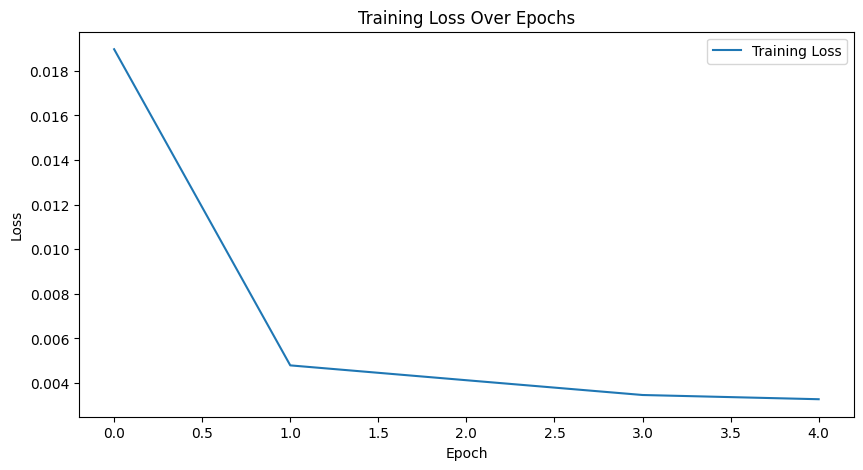

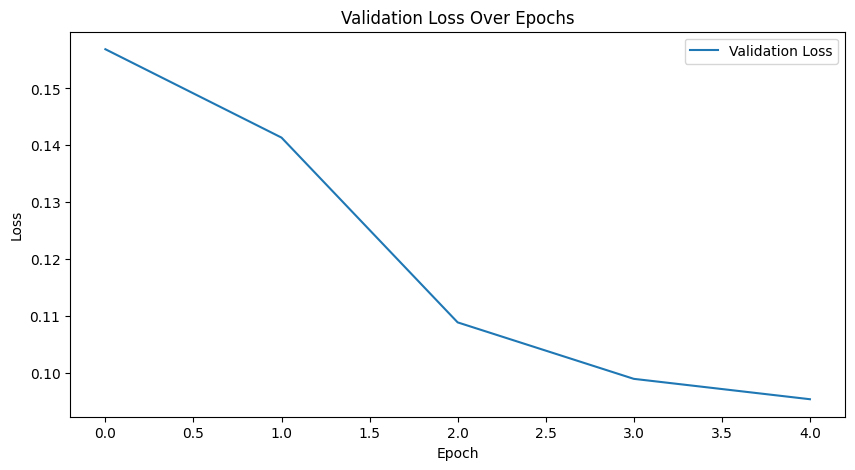


🔹 Loss & Learning Rate Graphs Saved.



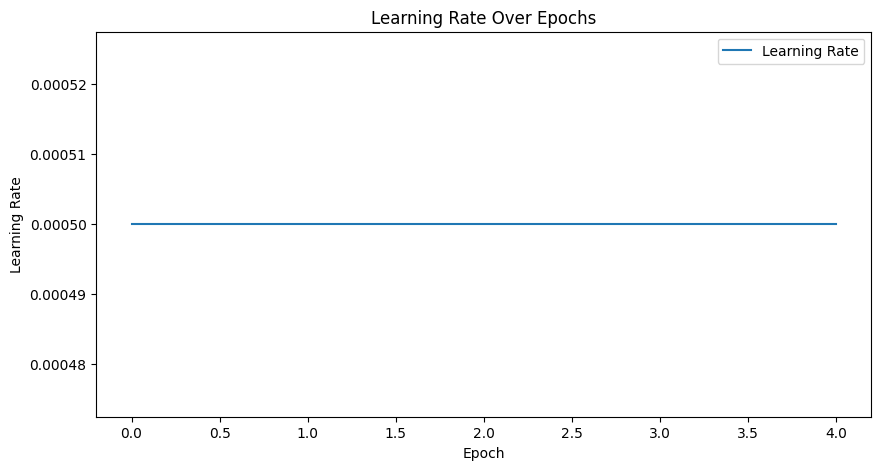

In [29]:
# Save Loss & Learning Rate Graph
save_loss_graphs(MAE_training_losses, MAE_validation_losses, MAE_lrs)

In [30]:
import matplotlib.pyplot as plt
import torch

# ✅ MAE Test: Origin vs Reconstruction (for each class)
def test_mae_reconstruction_per_class(model, test_loader, class_name):
    model.eval()
    images, _ = next(iter(test_loader))  # Bringing Samples from the Test Set
    images = images.to(device)

    with torch.no_grad():
        reconstructed = model(images)  # Predicting MAE model (Reconstruction)

    # Move images back to CPU for visualization
    images = images.cpu()
    reconstructed = reconstructed.cpu()

    # Plot original and reconstructed images
    plt.figure(figsize=(12, 4))
    for i in range(4):  # Plotting 4 Samples
        plt.subplot(2, 4, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f"{class_name} - Original")
        plt.axis('off')

        plt.subplot(2, 4, i+5)
        plt.imshow(reconstructed[i].squeeze(), cmap='gray')
        plt.title(f"{class_name} - Reconstructed")
        plt.axis('off')

    plt.tight_layout()
    plt.savefig(f"mae_test_reconstruction_{class_name}.png")
    plt.show()
    print(f"\n🔹 MAE Test Reconstruction Images Saved: mae_test_reconstruction_{class_name}.png\n")

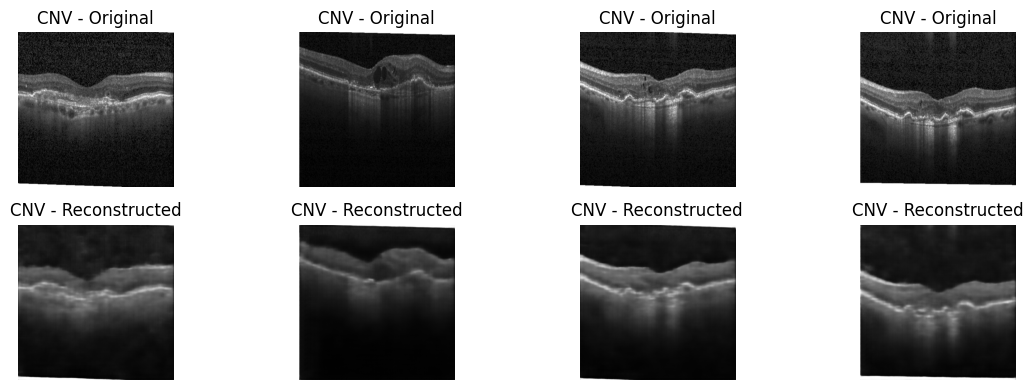


🔹 MAE Test Reconstruction Images Saved: mae_test_reconstruction_CNV.png



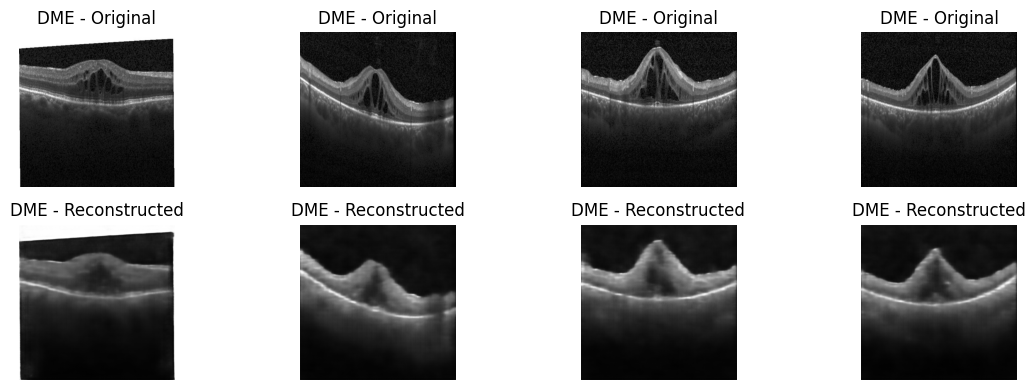


🔹 MAE Test Reconstruction Images Saved: mae_test_reconstruction_DME.png



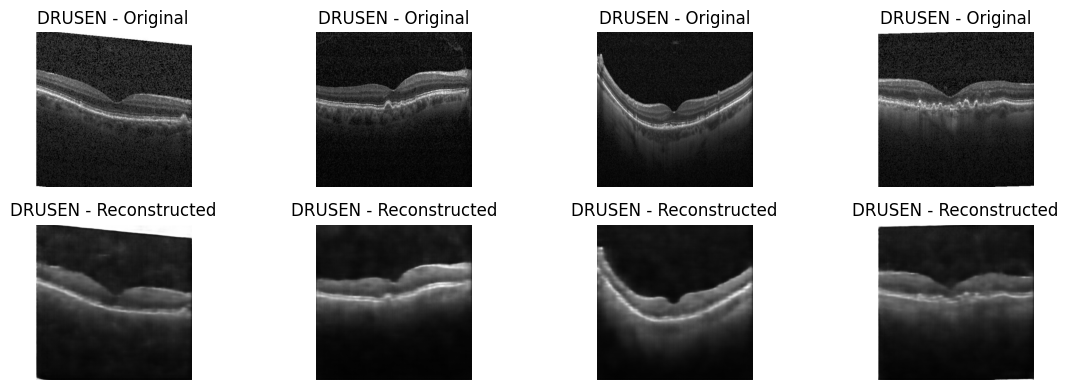


🔹 MAE Test Reconstruction Images Saved: mae_test_reconstruction_DRUSEN.png



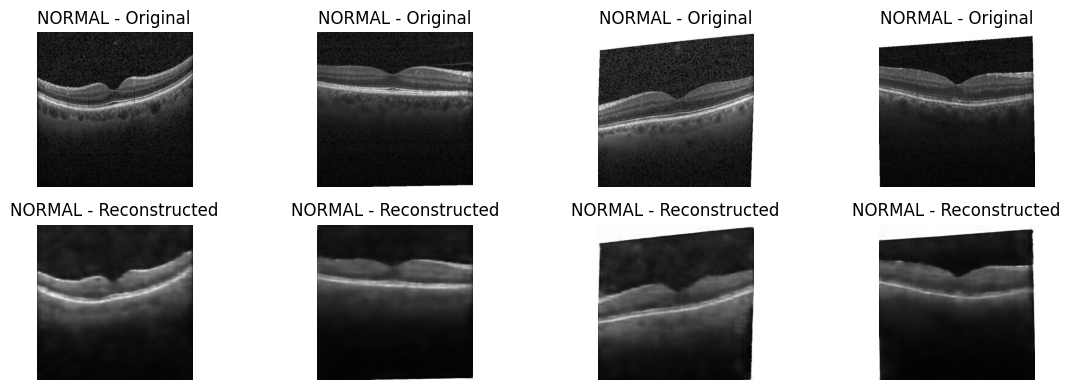


🔹 MAE Test Reconstruction Images Saved: mae_test_reconstruction_NORMAL.png



In [31]:
# ✅ Activate Tests of MAE Reconstruction for each class
test_mae_reconstruction_per_class(model, test_loader_CNV, "CNV")
test_mae_reconstruction_per_class(model, test_loader_DME, "DME")
test_mae_reconstruction_per_class(model, test_loader_DRUSEN, "DRUSEN")
test_mae_reconstruction_per_class(model, test_loader_NORMAL, "NORMAL")

In [32]:
import torch.nn as nn

class MAEClassifier(nn.Module):
    def __init__(self, mae_encoder, num_classes=4, freeze_encoder=True):
        super(MAEClassifier, self).__init__()
        self.encoder = mae_encoder  # Using the Encoder Part of the MAE

        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False  # 🔹 Freezing the Weights of the Encoder

        self.fc = nn.Linear(512*32*32, num_classes)  # Adding the Linear Layer forClassification

    def forward(self, x):
        x = self.encoder(x)  # Extracting the Feature using the MAE Encoder
        x = torch.flatten(x, start_dim=1)  # Processing Flattening
        x = self.fc(x)  # Going through the Fully Connected Layer
        return x

In [33]:
# Loading MAE Model (Using Encoder as Feature Extractor)
model.load_state_dict(torch.load('model.pt', weights_only=True))

# Setting Device (Forcing GPU Only)
device = torch.device("cuda")  # Only GPU (Error if GPU is unavailable)
model.to(device)

# Using the Encoder Part of the MAE as a Feature Extractor (Freezing)
mae_encoder = model.encoder
classifier = MAEClassifier(mae_encoder, num_classes=4).to(device)

# Setting Loss Function (CrossEntropyLoss for Classification)
criterion = nn.CrossEntropyLoss()

# Optimizer / Learning Rate Scheduler (Only Updating Classification Layer)
optimizer = torch.optim.Adam(classifier.parameters(), lr=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.6, patience=5)

In [34]:
def train_classifier(classifier, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs):
    Class_training_losses = []
    Class_validation_losses = []
    Class_lrs = []

    for epoch in range(num_epochs):
        classifier.train()
        epoch_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = classifier(images)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_accuracy = 100 * correct / total
        Class_training_losses.append(epoch_loss / len(train_loader))
        print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {epoch_loss/len(train_loader):.4f} | Train Acc: {train_accuracy:.2f}%")

        # ✅ Validation Step
        classifier.eval()
        val_epoch_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for val_images, val_labels in valid_loader:
                val_images, val_labels = val_images.to(device), val_labels.to(device)
                val_outputs = classifier(val_images)
                val_loss = criterion(val_outputs, val_labels)
                val_epoch_loss += val_loss.item()

                _, val_predicted = torch.max(val_outputs, 1)
                val_correct += (val_predicted == val_labels).sum().item()
                val_total += val_labels.size(0)

        val_accuracy = 100 * val_correct / val_total
        Class_validation_losses.append(val_epoch_loss / len(valid_loader))
        print(f"Epoch {epoch+1}/{num_epochs} | Val Loss: {val_epoch_loss/len(valid_loader):.4f} | Val Acc: {val_accuracy:.2f}%")

        scheduler.step(val_epoch_loss)
        Class_lrs.append(optimizer.param_groups[0]['lr'])

    return Class_training_losses, Class_validation_losses, Class_lrs

Epoch 1/50 | Train Loss: 2.1594 | Train Acc: 87.25%
Epoch 1/50 | Val Loss: 21.3865 | Val Acc: 39.62%
Epoch 2/50 | Train Loss: 1.0160 | Train Acc: 93.29%
Epoch 2/50 | Val Loss: 29.6014 | Val Acc: 37.50%
Epoch 3/50 | Train Loss: 1.5608 | Train Acc: 91.46%
Epoch 3/50 | Val Loss: 23.9932 | Val Acc: 41.00%
Epoch 4/50 | Train Loss: 1.5656 | Train Acc: 90.88%
Epoch 4/50 | Val Loss: 18.4780 | Val Acc: 47.88%
Epoch 5/50 | Train Loss: 1.5942 | Train Acc: 91.71%
Epoch 5/50 | Val Loss: 17.0207 | Val Acc: 45.00%
Epoch 6/50 | Train Loss: 0.2189 | Train Acc: 98.04%
Epoch 6/50 | Val Loss: 13.2071 | Val Acc: 48.50%
Epoch 7/50 | Train Loss: 0.0755 | Train Acc: 99.21%
Epoch 7/50 | Val Loss: 14.4083 | Val Acc: 48.38%
Epoch 8/50 | Train Loss: 0.1632 | Train Acc: 98.50%
Epoch 8/50 | Val Loss: 15.1506 | Val Acc: 48.38%
Epoch 9/50 | Train Loss: 0.0601 | Train Acc: 99.46%
Epoch 9/50 | Val Loss: 13.3658 | Val Acc: 47.75%
Epoch 10/50 | Train Loss: 0.0911 | Train Acc: 99.12%
Epoch 10/50 | Val Loss: 14.0714 | Val 

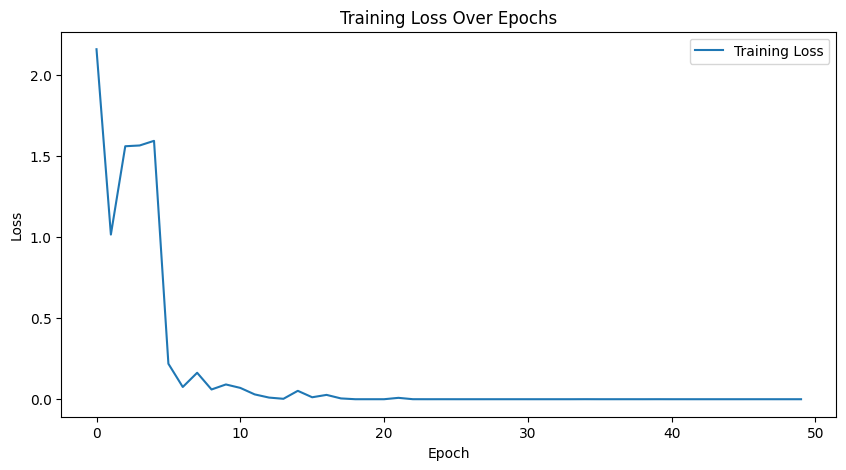

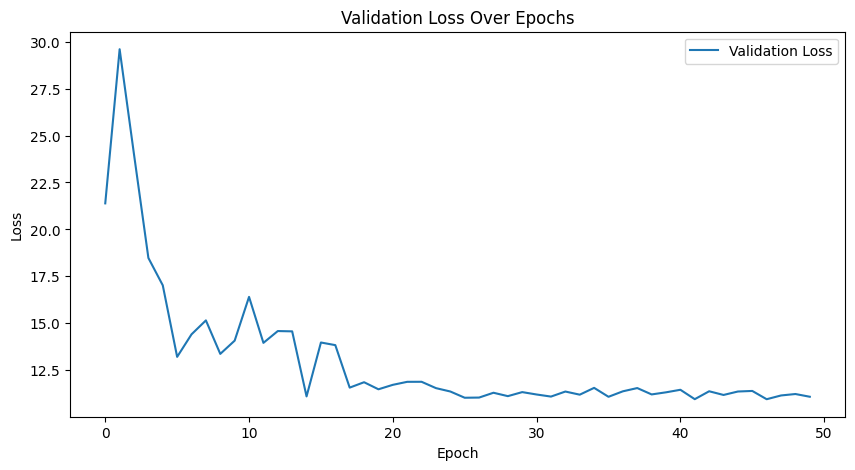


🔹 Loss & Learning Rate Graphs Saved.



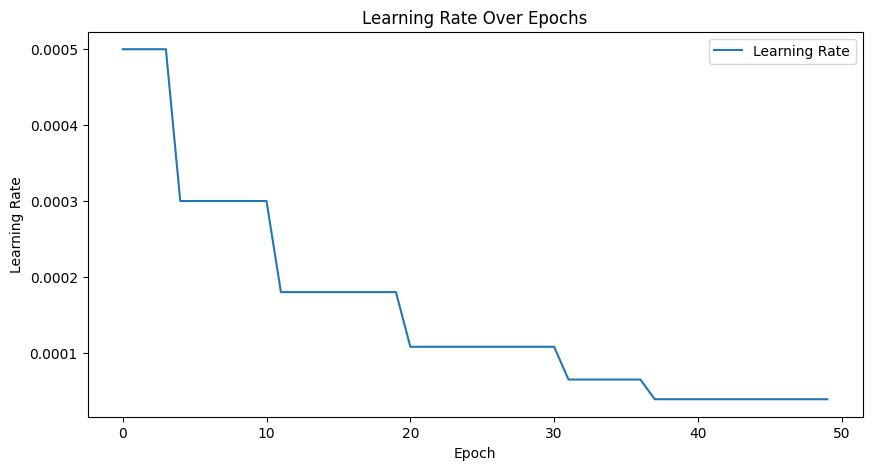

In [38]:
num_epochs = 50  # ✅ Epochs to Train

# ✅ Start Training
Class_training_losses, Class_validation_losses, Class_lrs = train_classifier(
    classifier, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs
)

# ✅ Save Loss and Learning Rate Graph
save_loss_graphs(Class_training_losses, Class_validation_losses, Class_lrs)

In [39]:
# ✅ Classification Test: Origin vs Predicted Labels (정확도 포함)
class_names = ["CNV", "DME", "DRUSEN", "NORMAL"]
def test_classification_predictions(classifier, test_loader, num_samples=200):
    classifier.eval()
    count = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # ✅ 모델 예측
            outputs = classifier(images)
            _, predicted = torch.max(outputs, 1)  # ✅ 가장 높은 확률을 가진 클래스 선택

            # ✅ 정확도 계산 (정답 개수 / 총 개수)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            # ✅ 결과 출력 (최대 num_samples개까지)
            for i in range(images.shape[0]):
                true_label = class_names[labels[i].item()]
                predicted_label = class_names[predicted[i].item()]
                correct_symbol = "✅" if true_label == predicted_label else "❌"

                print(f"Sample {count+1}: GT: {true_label} | Predicted: {predicted_label} {correct_symbol}")

                count += 1
                if count >= num_samples:
                    accuracy = 100 * correct / total
                    print(f"\n🔹 Overall Test Accuracy: {accuracy:.2f}% ({correct}/{total})")
                    return

    # ✅ 전체 테스트 데이터에 대한 정확도 출력
    accuracy = 100 * correct / total
    print(f"\n🔹 Final Test Accuracy: {accuracy:.2f}% ({correct}/{total})")

In [42]:
# Classification 모델 Test (예측 결과 출력)
test_classification_predictions(classifier, test_loader, num_samples=400)

Sample 1: GT: CNV | Predicted: CNV ✅
Sample 2: GT: CNV | Predicted: DRUSEN ❌
Sample 3: GT: CNV | Predicted: CNV ✅
Sample 4: GT: CNV | Predicted: DRUSEN ❌
Sample 5: GT: CNV | Predicted: CNV ✅
Sample 6: GT: CNV | Predicted: CNV ✅
Sample 7: GT: CNV | Predicted: CNV ✅
Sample 8: GT: CNV | Predicted: DRUSEN ❌
Sample 9: GT: CNV | Predicted: DRUSEN ❌
Sample 10: GT: CNV | Predicted: DME ❌
Sample 11: GT: CNV | Predicted: CNV ✅
Sample 12: GT: CNV | Predicted: DRUSEN ❌
Sample 13: GT: CNV | Predicted: CNV ✅
Sample 14: GT: CNV | Predicted: CNV ✅
Sample 15: GT: CNV | Predicted: CNV ✅
Sample 16: GT: CNV | Predicted: DRUSEN ❌
Sample 17: GT: CNV | Predicted: NORMAL ❌
Sample 18: GT: CNV | Predicted: DME ❌
Sample 19: GT: CNV | Predicted: DME ❌
Sample 20: GT: CNV | Predicted: DME ❌
Sample 21: GT: CNV | Predicted: CNV ✅
Sample 22: GT: CNV | Predicted: DRUSEN ❌
Sample 23: GT: CNV | Predicted: CNV ✅
Sample 24: GT: CNV | Predicted: CNV ✅
Sample 25: GT: CNV | Predicted: CNV ✅
Sample 26: GT: CNV | Predicted: DME